# 1 探索数据


数据集使用 kaggle 数据集，解压后存放在images目录下
- 训练数据集路径：
images/train
- 测试数据集路径：
images/test

# 1.1 整理数据集
 
这里由于 trian 文件夹下的猫和狗的数据是混在一起的，需要将猫和狗的图片分别存储。

图片的命名规则：类别.编码.jpg

**注意：这里的处理只需要运行一次即可**


In [1]:
import os
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import mode as spmode
from PIL import ImageFile
from PIL import Image
import platform

print(platform.system())

Linux


In [2]:
# windows分隔符
splitflag = "\\"
if (platform.system() == 'Linux'):
    splitflag = "/"

#处理的样本量
limitcount = 100

def create_dir(path):
    '''
    创建文件夹
    '''
    if (os.path.exists(path) == False):
        os.mkdir (path)
    else:
        print('文件夹已经存在：%s' % path)

# 限制训练文件数量,0不限制
def copy_image_bytype(srcpath, destpath, limitcount = 0):
    '''
    将猫狗文件分别拷贝到不同文件夹下
    '''
    
    filenames = [item.split(splitflag)[-1] for item in sorted(srcpath)]
    
    count = 0
    for src,name in zip(srcpath,filenames):
        dst = destpath + "/" + name
        if (os.path.exists(dst) == False):
            shutil.copyfile(src, dst)

        count += 1
        
        # 跳出循环
        if (limitcount == count):
            break
            
    return count

def file_move(srcpath, despath):
    filenames = [item.split(splitflag)[-1] for item in sorted(srcpath)]
    count = len(filenames)
        
    for src,name in zip(srcpath,filenames):
        dst = despath + "/" + name
        if (os.path.exists(src) == True):
            shutil.move(src, dst)
            
    return count
        
    

In [3]:
# 创建文件夹
notmatch_path='images/notmatchs'
all_path = 'images/all'
train_path = 'images/all/trainnew'
dog_path = 'images/all/trainnew/dogs'
cat_path = 'images/all/trainnew/cats'

testnew_path = 'images/all/testnew'
test_path = 'images/all/testnew/test'

create_dir(notmatch_path)
create_dir(all_path)

create_dir(train_path)
create_dir(dog_path)
create_dir(cat_path)

create_dir(testnew_path)
create_dir(test_path)


In [4]:
# 处理狗
dogs_all = glob("images/train/dog.*")

# 整理狗数据
count = copy_image_bytype(dogs_all, dog_path, limitcount)

print('There are %d total dog categories.' % count)


There are 100 total dog categories.


In [5]:
# 处理猫
cats_all = glob("images/train/cat.*")

# 整理猫数据
count = copy_image_bytype(cats_all, cat_path, limitcount)

print('There are %d total cat categories.' % count)


There are 100 total cat categories.


In [6]:
# 处理测试数据
test_all = glob("images/test/*")

# 整理猫数据
count = copy_image_bytype(test_all, test_path, limitcount)

print('There are %d total test categories.' % count)


There are 100 total test categories.


In [7]:
#当前使用的样例
dogs_list = glob(dog_path+'/dog.*')
cats_list = glob(cat_path+'/cat.*')
test_list = glob(test_path+'/*')

print(len(dogs_list))
print(len(cats_list))
print(len(test_list))

100
100
100


## 1.2 数据可视化

In [8]:


def get_filesizes(paths):
    '''
    获取文件大小
    '''
    filesizes = []
    for path in paths:
        size = os.path.getsize(path)
        filesizes.append(size)
    return filesizes

def get_filepixs(paths):
    '''
    获取像素：长和宽
    '''
    filepixs = []
    xpixs = []
    ypixs = []
    for path in paths:
        img = Image.open(path)
        pix = img.size #图片的长和宽
        xpixs.append(pix[0]) #图片的宽
        ypixs.append(pix[1]) #图片的长
        if (pix[0] > 1000):
            print(path)
    filepixs.append(xpixs)
    filepixs.append(ypixs)    
    
    return filepixs
    
def draw_hist(mylist, title, xlabel, ylabel, xmin, xmax, ymin, ymax):
    '''
    绘制直方图，参数依次为list,抬头,X轴标签,Y轴标签,XY轴的范围
    '''
    plt.hist(mylist, 100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
def draw_scatter(x1, y1, title, label):
    '''
    绘制像素的散点图
    '''
    plt.scatter(x1, y1, marker = 'x',color = 'red', s = 40 ,label = label)
    plt.xlabel('wide')
    plt.ylabel('length')
    plt.title(title)
    
#     plt.xlim(-1.5, 1.5)
#     plt.xticks(())  # ignore xticks
#     plt.ylim(-1.5, 1.5)
#     plt.yticks(())  # ignore yticks

    plt.show()   

    
def show_filesize(paths):
    '''
    展示文件大小分布
    '''
    filesizes = get_filesizes(paths)

    # train 中文件的的最小值、最大值、中位数、众数
    train_min = np.min(filesizes)
    print('train 中文件的的最小值:', train_min)
    train_max = np.max(filesizes)
    print('train 中文件的的最大值:', train_max)
    train_median = np.median(filesizes)
    print('train 中文件的的中位数:', train_median)
    train_mode = spmode(filesizes)
    print('train 中文件的的众数:', train_mode)
        
    title = 'file size distribute'
    xlabel = 'file size'
    ylabel = 'file count'
    xmin = np.min(filesizes)
    xmax = np.max(filesizes)
    ymin = 0
    ymax = 1200
    draw_hist(filesizes, title, xlabel, ylabel, xmin, xmax, ymin, ymax)

def show_filepix(paths):
    '''
    显示像素分布
    '''
    filepixs = get_filepixs(paths)
    title = 'file pix distribute'
    draw_scatter(filepixs[0], filepixs[1], title, 'dog')    

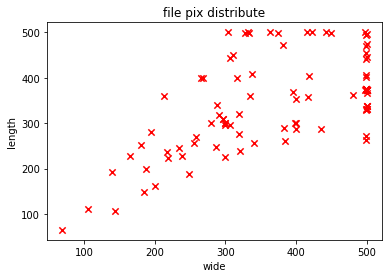

In [9]:
# 狗的数据集图片大小分布

show_filepix(dogs_list)

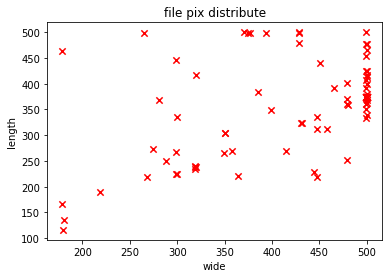

In [10]:
# 猫的数据集图片大小分布
show_filepix(cats_list)

In [11]:
# 训练数据集文件大小的分布
# show_filesize(dogs_list)        


In [12]:
# 测试数据集文件大小的分布
# show_filesize(cats_list)        


## 1.4 数据预处理

### 1.4.1 异常数据清理

异常数据有:

标签与图片信息不相符的，例如：虽然标识了是狗的图片，但是图片中没有狗。

照片的背景过于复杂，识别起来很困难，例如：虽然有狗但是有很多干扰元素。

这里选择4种算法:ResNet50, VGG19, Xception, InceptionV3 获取的并集进行数据清理



In [13]:
from keras.preprocessing import image


#可能概率前几个类型
topparma = 50
doglimit = 10
catlimit = 10


# 对 ImageNet 分类进行分析
# 狗分类：118种，猫分类：7种

ImageNetdogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

ImageNetcats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

Using TensorFlow backend.


In [14]:
def get_not_animalarray(model, top, animalarray,img_paths, xsize, ysize):
    '''
    清理数据集中不是对应标签的文件
    model:模型
    top:可能概率前几个类型
    animalarray: ImageNet分类集
    img_paths:数据集路径
    x:图片宽
    y:图片高
    '''
    animals = []
    for img_path in img_paths:
        img = image.load_img(img_path, target_size=(xsize, ysize))
        imgarray = image.img_to_array(img)
        imgarray = np.expand_dims(imgarray, axis=0)
        imgarray = preprocess_input(imgarray)

        preds = model.predict(imgarray)
        predarray = decode_predictions(preds, top=top)
#         sorted(tmparray, key=lambda tmp: tmp[2], reverse=True) 

        # 判断是否有指定类型存在
        existflag = False
        for n in range(top):
            animal = predarray[0][n][0]
            if animal in animalarray:
                existflag = True
                break
        if existflag == False:
            animals.append(img_path)
            
    return animals

# [[('n02092002', 'Scottish_deerhound', 0.21568948),('n02097130', 'giant_schnauzer', 0.074100845)]]

#### 利用ResNet50网络进行ImageNet分类

In [15]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


ResNet50_model = ResNet50(weights='imagenet')

# 不是狗的
ResNet50_notdogs = get_not_animalarray(ResNet50_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 224, 224)
print(ResNet50_notdogs)

# 不是猫的
ResNet50_notcats = get_not_animalarray(ResNet50_model, topparma, ImageNetcats, cats_list[0:catlimit], 224, 224)
print(ResNet50_notdogs)   

[]
[]


#### 利用VGG19网络进行ImageNet分类

In [16]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input,decode_predictions


VGG19_model = VGG19(weights='imagenet')

# 不是狗的
VGG19_notdogs = get_not_animalarray(VGG19_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 224, 224)
print(VGG19_notdogs)

# 不是猫的
VGG19_notcats = get_not_animalarray(VGG19_model, topparma, ImageNetcats, cats_list[0:catlimit], 224, 224)
print(VGG19_notcats)   

[]
[]


#### 利用Xception网络进行ImageNet分类

In [17]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input,decode_predictions


Xception_model = Xception(weights='imagenet')

# 不是狗的
Xception_notdogs = get_not_animalarray(Xception_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 299, 299)
print(Xception_notdogs)

# 不是猫的
Xception_notcats = get_not_animalarray(Xception_model, topparma, ImageNetcats, cats_list[0:catlimit], 299, 299)
print(Xception_notcats) 

[]
[]


#### 利用InceptionV3网络进行ImageNet分类

In [18]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input,decode_predictions

InceptionV3_model = InceptionV3(weights='imagenet')

# 不是狗的
InceptionV3_notdogs = get_not_animalarray(InceptionV3_model, topparma, ImageNetdogs, dogs_list[0:doglimit], 299, 299)
print(InceptionV3_notdogs)

# 不是猫的
InceptionV3_notcats = get_not_animalarray(InceptionV3_model, topparma, ImageNetcats, cats_list[0:catlimit], 299, 299)
print(InceptionV3_notcats) 

[]
[]


In [19]:
# 合并所有的结果，取并集
notdogs = ResNet50_notdogs + VGG19_notdogs + Xception_notdogs + InceptionV3_notdogs
notdogs = list(set(notdogs))
print(notdogs)

notcats = ResNet50_notcats + VGG19_notcats + Xception_notcats + InceptionV3_notdogs
notcats = list(set(notcats))
print(notcats)


notmatchs = notdogs + notcats

[]
[]


In [20]:
import cv2
import  matplotlib.pyplot as plt

def show_multiple_image(images):
    '''
    展示多组图片
    '''
    count = 1
    row = len(images) / 4
    col = 4
    if (row < 1):
        row = 1
    for image in images:
        plt.figure(num='astronaut', figsize =(12,15))  #创建一个名为astronaut的窗口,并设置大小 
        img = plt.imread(image)  
        if (count == 1):
            plt.subplot(row,col,count)     #将窗口分为两行两列四个子图，则可显示四幅图片
            plt.title(image.split(splitflag)[-1])   #第一幅图片标题l
            plt.imshow(img)      #绘制第一幅图片
        else:
            plt.subplot(row,col,count)     #第三个子图
            plt.title(image.split(splitflag)[-1])   #第一幅图片标题l
            plt.imshow(img)      #绘制第一幅图片

        if (count >= 8):
            count += 1
        else:
            count += 1

    plt.show()   #显示窗口


# test1=['images/all/testnew/test\\1.jpg', 'images/all/testnew/test\\10.jpg', 'images/all/testnew/test\\100.jpg', 'images/all/testnew/test\\1000.jpg']    
# test2=['images/all/testnew/test\\1.jpg', 'images/all/testnew/test\\10.jpg', 'images/all/testnew/test\\100.jpg', 'images/all/testnew/test\\1000.jpg']    
# test3=['images/all/testnew/test\\1.jpg', 'images/all/testnew/test\\10.jpg', 'images/all/testnew/test\\100.jpg', 'images/all/testnew/test\\1000.jpg']    
# test4=['images/all/testnew/test\\101.jpg', 'images/all/testnew/test\\102.jpg', 'images/all/testnew/test\\100.jpg', 'images/all/testnew/test\\1000.jpg']    
# test5=[]
# test = test1+ test2 + test3 + test4
print(len(notmatchs))
show_multiple_image(notmatchs)    

0


#### 剔除异常数据

In [21]:
# 剔除异常数据
file_move(notmatchs, notmatch_path)

0

### 1.4.2 分割数据集

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adagrad
from sklearn.datasets import load_files
from keras.utils import np_utils


    

In [23]:
from sklearn.model_selection import train_test_split


# 加载 train 测试数据集
train_data = load_files(train_path)

# 加载 test 测试数据集
test_data = load_files(testnew_path)    

trainall_file = np.array(train_data['filenames'])
trainall_targets = np_utils.to_categorical(np.array(train_data['target']), 2)
# print(type(train_data))
# print(train_targets)

# 展示训练数据集
print('训练集数据总数：%d' % len(trainall_file))


# 将原来的训练数据分割成训练数据集和验证数据集，比例为20%
train_files, valid_files, train_targets, valid_targets = train_test_split(trainall_file, trainall_targets, test_size=0.2)

print(len(train_files))
print(len(valid_files))
# print(tarin_targets)
# print(valid_targets)


test_files = np.array(test_data['filenames'])
test_targets = np_utils.to_categorical(np.array(test_data['target']), 1)

# 展示测试数据集
print('测试集数据总数：%d' % len(test_files))


训练集数据总数：200
160
40
测试集数据总数：100


### 1.4.3 图像预处理

通过对每张图像的像素值除以299，我们对图像实现了归一化处理

In [24]:
from keras.preprocessing import image
from tqdm import tqdm
from PIL import ImageFile  

ImageFile.LOAD_TRUNCATED_IMAGES = True                 

def path_to_tensor(img_path):
#     print(img_path)
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path,target_size=(299,299))
    
    #将PIL.Image.Image类型转化为格式为(299,299,3)的3维张量
    x = image.img_to_array(img)
    
    #将3维张量转化为格式为(1, 299, 299, 3) 的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# img_path='images/all/train/trainnew/cats/cat.4424.jpg'
# path_to_tensor(img_path)




#### 归一化处理

In [25]:
starttime = time.strftime('start time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (starttime)

# 训练集预处理
train_tensors = paths_to_tensor(train_files).astype('float32')/127.5 - 1


endtime = time.strftime('end time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (endtime)

  0%|          | 0/160 [00:00<?, ?it/s]

start time:2018-09-16 04:05:39


100%|██████████| 160/160 [00:00<00:00, 329.96it/s]


end time:2018-09-16 04:05:39


In [26]:
starttime = time.strftime('start time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (starttime)

# 验证集预处理
valid_tensors = paths_to_tensor(valid_files).astype('float32')/127.5 - 1


endtime = time.strftime('end time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (endtime)

100%|██████████| 40/40 [00:00<00:00, 345.51it/s]

start time:2018-09-16 04:05:39
end time:2018-09-16 04:05:39


In [27]:
starttime = time.strftime('start time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (starttime)

# 测试集预处理
test_tensors = paths_to_tensor(test_files).astype('float32')/127.5 - 1

endtime = time.strftime('end time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (endtime)

  0%|          | 0/100 [00:00<?, ?it/s]

start time:2018-09-16 04:05:39


100%|██████████| 100/100 [00:00<00:00, 347.89it/s]


end time:2018-09-16 04:05:40


# 2 构建模型



## 2.1 训练模型

训练 InceptionV3 模型

In [28]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

# logloss 趋势图
def show_logloss(history_callback):
    plt.plot(history_callback.history['loss'])
    plt.plot(history_callback.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train","valid"],loc="upper left")

    plt.show()

# 准确率趋势图
def show_acc(history_callback):
    plt.plot(history_callback.history['acc'])
    plt.plot(history_callback.history['val_acc'])
    plt.title("model acc")
    plt.ylabel("acc")
    plt.xlabel("epoch")
    plt.legend(["train","test"],loc="upper left")

    plt.show()

In [29]:
# 1.构建不带分类器的预训练模型
base_model = InceptionV3(weights='imagenet',include_top=False) 

In [30]:
# 2.添加全局平均池化层
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [31]:
# 3.全连接层，可选，如果精度够用则可以不加
# x = Dense(1024, activation='relu')(x)


In [32]:
# 4. 添加一个分类器，使用 1 个神经元，sigmoid激活函数
predictions = Dense(2, activation='sigmoid')(x)


In [33]:
# 5. 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)


In [34]:
# 6.首先只训练顶部的几层（随机初始化的层），锁住所有 InceptionV3d 卷积层
for layer in base_model.layers:
    layer.trainable = False


In [35]:
starttime = time.strftime('start time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (starttime)

# 7.编译模型（一定要在锁层以后操作）
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')


endtime = time.strftime('end time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (endtime)

start time:2018-09-16 04:06:14
end time:2018-09-16 04:06:14


In [36]:
starttime = time.strftime('start time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (starttime)

# 8. 在新的数据集上训练几代
# early stoppping 
from keras.callbacks import EarlyStopping

# monitor: 需要监视的变量
# patience:在发现变量没有变化后的多少个epoch停止
# verbose:信息展示模式
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

tensorboard = TensorBoard(log_dir='log')
callback_lists = [tensorboard, early_stopping]
history_callback = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=300, batch_size=64, verbose=1, callbacks=callback_lists)


endtime = time.strftime('end time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (endtime)

start time:2018-09-16 04:06:14
Train on 160 samples, validate on 40 samples
Epoch 1/300
160/160 [==============================] - 16s - loss: 0.7077 - val_loss: 0.5459
Epoch 2/300
160/160 [==============================] - 15s - loss: 0.4977 - val_loss: 0.3865
Epoch 3/300
160/160 [==============================] - 15s - loss: 0.3387 - val_loss: 0.2848
Epoch 4/300
160/160 [==============================] - 15s - loss: 0.3101 - val_loss: 0.4596
Epoch 5/300
160/160 [==============================] - 15s - loss: 0.2753 - val_loss: 0.2261
Epoch 6/300
160/160 [==============================] - 15s - loss: 0.1857 - val_loss: 0.2790
Epoch 7/300
160/160 [==============================] - 15s - loss: 0.1710 - val_loss: 0.1983
Epoch 8/300
160/160 [==============================] - 15s - loss: 0.1516 - val_loss: 0.1673
Epoch 9/300
160/160 [==============================] - 15s - loss: 0.1602 - val_loss: 0.2181
Epoch 10/300
160/160 [==============================] - 15s - loss: 0.1200 - val_loss: 

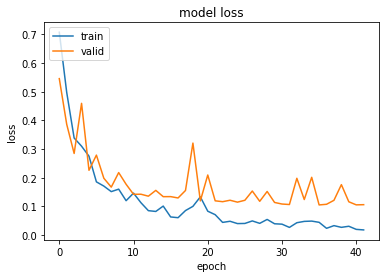

In [37]:
# 展示logloss趋势
show_logloss(history_callback)

In [38]:
# 9.现在顶层应该训练好了，开始微调 InceptionV3的卷积层。
#锁住底下的几层，然后训练其余的顶层。查看每一层的名字和层号，看看应该锁多少层
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name)
 

In [39]:
# 10.我们选择训练最上面的两个 Inception block, 锁住前面249层，然后放开之后的层
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True


In [41]:
from keras.optimizers import SGD

# 11.重新编译模型，使上面的修改生效，设置一个很低的学习率:lr=0.001，使用SGD来微调
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])
print('compile ok')

compile ok


In [42]:


starttime = time.strftime('start time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (starttime)

# 12.继续训练模型，训练最后两个 Inception block 和两个全连接层
Inceptionfile_hdf5 ='saved_models/weights.best.Inception.hdf5'

# 模型保存
checkpointer = ModelCheckpoint(filepath=Inceptionfile_hdf5, verbose=1, save_best_only=True)

# 可视化
tensorboard = TensorBoard(log_dir='log')

# 自动停止训练
# monitor: 需要监视的变量
# patience:在发现变量没有变化后的多少个epoch停止
# verbose:信息展示模式
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


callback_lists = [tensorboard, checkpointer, early_stopping]

# # 训练模型
history_callback = model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets),
         epochs=300, batch_size=64,callbacks=callback_lists,shuffle='True',verbose=1)


endtime = time.strftime('end time:%Y-%m-%d %H:%M:%S', time.localtime()) 
print (endtime)

start time:2018-09-16 04:27:49
Train on 160 samples, validate on 40 samples
Epoch 1/300
160/160 [==============================] - 41s - loss: 0.0196 - acc: 1.0000 - val_loss: 0.1071 - val_acc: 0.9250
Epoch 2/300
160/160 [==============================] - 18s - loss: 0.0236 - acc: 1.0000 - val_loss: 0.1075 - val_acc: 0.9250
Epoch 3/300
160/160 [==============================] - 18s - loss: 0.0260 - acc: 1.0000 - val_loss: 0.1078 - val_acc: 0.9250
Epoch 4/300
160/160 [==============================] - 18s - loss: 0.0144 - acc: 1.0000 - val_loss: 0.1087 - val_acc: 0.9500
Epoch 5/300
160/160 [==============================] - 18s - loss: 0.0129 - acc: 1.0000 - val_loss: 0.1096 - val_acc: 0.9500
Epoch 6/300
160/160 [==============================] - 18s - loss: 0.0137 - acc: 1.0000 - val_loss: 0.1109 - val_acc: 0.9500
Epoch 7/300
160/160 [==============================] - 18s - loss: 0.0104 - acc: 1.0000 - val_loss: 0.1122 - val_acc: 0.9500
Epoch 00006: early stopping
end time:2018-09-16 0

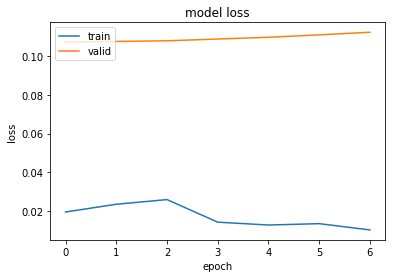

In [43]:
# 展示logloss趋势
show_logloss(history_callback)

## 2.2 测试模型

在测试数据集上试用训练后的模型

In [66]:
import pandas as pd
from keras.preprocessing.image import *

## 加载具有最好验证loss的模型
starttime = time.strftime('start time:%Y.%m.%d %H:%M:%S',time.localtime(time.time()))
print (starttime)

model.load_weights(Inceptionfile_hdf5)

# # 获取测试数据集中每一个图像所预测的狗品种的index
# dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
# # 报告测试准确率
# test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
# print('Test accuracy: %.4f%%' % test_accuracy)


y_pred = model.predict(test_tensors, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
print(testnew_path)
test_generator = gen.flow_from_directory(testnew_path, (299, 299), shuffle=False, 
                                         batch_size=16, class_mode=None)

endtime = time.strftime('end time:%Y.%m.%d %H:%M:%S',time.localtime(time.time()))
print (endtime)



start time:2018.09.16 05:03:20
100/100 [==============================] - 8s     
images/all/testnew
Found 100 images belonging to 1 classes.
end time:2018.09.16 05:03:28


In [71]:
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i][0])

df.to_csv('pred.csv', index=None)
df.head(10)

,id,label
0,1,0.005000
1,2,0.500000
2,3,0.500000
3,4,0.500000
4,5,0.500000
5,6,0.500000
6,7,0.500000
7,8,0.500000
8,9,0.500000
9,10,0.224833
